# Transfer learning
---
In this module, we will
 - analyze resnet nerural network architecture
 - make predictions over random images with resnet pretrained on ImageNet dataset (***http://www.image-net.org/***)
 - create out own dataset
 - finetune resnet for our custom dataset


In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

## Analysis of resnet 18

### Architecture
Inormation about accessible pretrained models for pytorch can be found at ***https://pytorch.org/docs/stable/torchvision/models.html***.

In [106]:
from torchvision import models

In [107]:
resnet18 = models.resnet18()
resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [108]:
conv1 = resnet18.layer4[0].conv1
conv1

Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)

### Prediction with pretrained model

In [112]:
from image_processing_workshop.utils import get_image_from_url
from image_processing_workshop.visual import plot_image
from torchvision import datasets, transforms
import numpy as np
import os
import torch

In [113]:
os.environ["TORCH_HOME"] = "./"

In [114]:
models.resnet.model_urls

{'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
 'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
 'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
 'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
 'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth'}

In [115]:
resnet18 = models.resnet18(pretrained=True)
info = resnet18.eval()

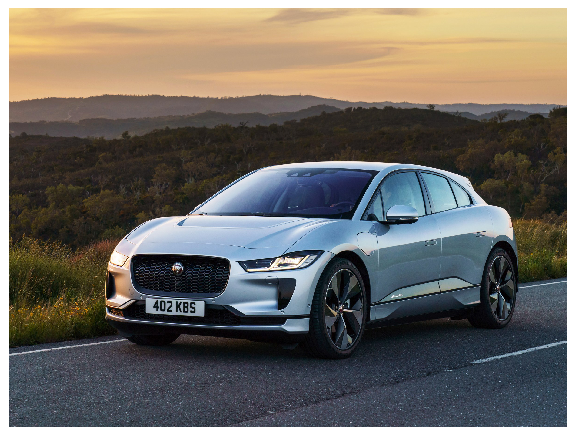

In [116]:
url = 'https://media.wired.com/photos/5b86fce8900cb57bbfd1e7ee/master/pass/Jaguar_I-PACE_S_Indus-Silver_065.jpg'
img = get_image_from_url(url)
plot_image(img)

In [117]:
# Transformation for resnet, normalization is important!
transformation = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

In [118]:
transformed_img = transformation(img)

In [119]:
img.shape, transformed_img.shape

((1800, 2400, 3), torch.Size([3, 224, 298]))

In [120]:
batch = transformed_img.unsqueeze(0)
resnet18(batch)[0][:10]

tensor([-1.0964, -2.3460, -0.1128, -1.9760, -1.0110, -1.7371, -1.0038, -0.4055,
        -0.7152,  0.5701], grad_fn=<SliceBackward>)

In [121]:
# Let's adjust last layer and add softmax, softmax doesn't need training, it's just normalization.
resnet18.fc = torch.nn.Sequential(
    resnet18.fc, 
    torch.nn.Softmax(dim=1))

In [122]:
resnet18(batch)[0][:10]

tensor([1.1077e-05, 3.1749e-06, 2.9622e-05, 4.5964e-06, 1.2065e-05, 5.8367e-06,
        1.2152e-05, 2.2105e-05, 1.6217e-05, 5.8641e-05],
       grad_fn=<SliceBackward>)

In [123]:
from image_processing_workshop.utils import get_imagenet_category_names
from image_processing_workshop.visual import plot_classify

In [124]:
get_imagenet_category_names(use_cache=True)[:10]

['tench',
 'goldfish',
 'great_white_shark',
 'tiger_shark',
 'hammerhead',
 'electric_ray',
 'stingray',
 'cock',
 'hen',
 'ostrich']

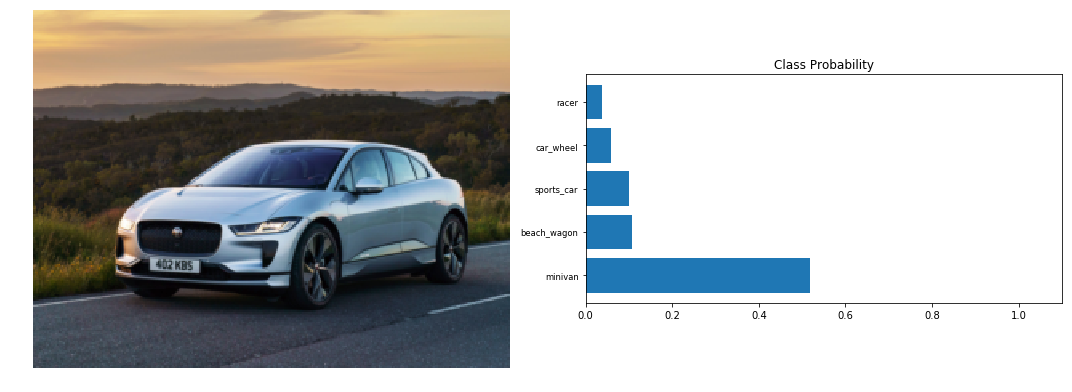

In [128]:
plot_classify(transformed_img, resnet18, topn=5, category_names=get_imagenet_category_names(), figsize=(15,15))

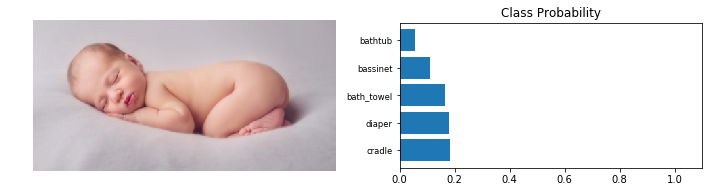

In [129]:
url = 'https://media2.s-nbcnews.com/i/newscms/2019_03/1402031/baby-name-today-main-190115_92c502d95f67cf1f7edc6851782a74c8.jpg'
img = get_image_from_url(url)
transformed_img = transformation(img)
plot_classify(transformed_img, resnet18, topn=5, category_names=get_imagenet_category_names())

## Our own custom dataset
Let's Google a few (2-4) image categories (diffrecent celebrities, few animal species, different cars, flowers etc..) and build dataset.

### 1 Scrape image url

 - go to Google images https://www.google.com/imghp?hl=EN
 - search image category and scroll a bit through it
 - run console `Ctrl-Shift-J`
 - paste snippet to console  

```javascript

javascript:document.body.innerHTML = `<a href="data:text/csv;charset=utf-8,${escape(Array.from(document.querySelectorAll('.rg_di .rg_meta')).map(el=>JSON.parse(el.textContent).ou).join('\n'))}" download="urls.txt">download urls</a>`;
```

 - rename appropriately download="urls.txt" 
 - download file with image urls
 - copy it to shared folder with ipython notebooks
 
 
### 2 Download images to proper folder hierarchy
 - run `scrape_urls` with url file and appropriate category name
 - each run of `scrape_urls` will create following folder hierarchy
 
`root_folder/train/class_name/*.jpg`   
`root_folder/valid/class_name/*.jpg`

In [131]:
from image_processing_workshop.utils import scrape_urls

In [132]:
root_folder = './dataset'

In [133]:
scrape_urls('dogs_url.txt', category_name='dogs')

  4%|▍         | 9/200 [00:28<08:17,  2.60s/it]

Not valid file: ./dataset/valid/dogs/puppy.jpg


  7%|▋         | 14/200 [00:30<02:16,  1.37it/s]

Not valid file: ./dataset/train/dogs/vicious_dog_0.jpg


 10%|▉         | 19/200 [00:34<01:56,  1.55it/s]

Not valid file: ./dataset/train/dogs/cloned_dogs_mdorottya_123rf.jpg


 12%|█▎        | 25/200 [00:36<01:16,  2.30it/s]

Not valid file: ./dataset/train/dogs/giphy.jpg


 13%|█▎        | 26/200 [00:36<01:07,  2.57it/s]

Not valid file: ./dataset/valid/dogs/300px-Dog_morphological_variation.jpg


 14%|█▍        | 29/200 [00:37<00:55,  3.09it/s]

HTTP Error 403: Forbidden


 16%|█▋        | 33/200 [00:48<06:27,  2.32s/it]

Not valid file: ./dataset/train/dogs/20180710-Dog-Breed-1.jpg


 20%|██        | 40/200 [00:54<02:37,  1.01it/s]

HTTP Error 403: Forbidden


 24%|██▍       | 49/200 [00:58<01:17,  1.94it/s]

HTTP Error 403: Forbidden


 32%|███▎      | 65/200 [01:07<00:45,  2.96it/s]

HTTP Error 403: Forbidden


 33%|███▎      | 66/200 [01:07<01:05,  2.06it/s]

HTTP Error 403: Forbidden


 36%|███▌      | 71/200 [01:09<00:38,  3.36it/s]

Not valid file: ./dataset/train/dogs/350px-Dog_coat_variation.jpg


 38%|███▊      | 77/200 [01:13<01:26,  1.43it/s]

Not valid file: ./dataset/train/dogs/?media_id=202825023077692.jpg


 41%|████      | 82/200 [01:21<01:52,  1.05it/s]

HTTP Error 403: Forbidden


 42%|████▏     | 84/200 [01:21<01:07,  1.72it/s]

HTTP Error 403: Forbidden


 42%|████▎     | 85/200 [01:22<01:20,  1.43it/s]

Not valid file: ./dataset/valid/dogs/7338659f-a9cc-4524-adf9-a3f1619bbb04-2019_03-19_Buck_Benson_shot_dog.jpg


 44%|████▍     | 89/200 [01:23<00:42,  2.62it/s]

HTTP Error 403: Forbidden


 48%|████▊     | 97/200 [01:28<01:05,  1.58it/s]

HTTP Error 403: Forbidden


 49%|████▉     | 98/200 [01:39<06:15,  3.69s/it]

Not valid file: ./dataset/valid/dogs/?media_id=92490953062.jpg


 52%|█████▏    | 103/200 [01:40<01:15,  1.28it/s]

Not valid file: ./dataset/train/dogs/883674efb399d88231accdaff2c7e2b4?width=650.jpg


 53%|█████▎    | 106/200 [01:41<00:39,  2.40it/s]

HTTP Error 403: Forbidden


 62%|██████▎   | 125/200 [02:03<00:54,  1.38it/s]

Not valid file: ./dataset/train/dogs/gal_7_233.jpg
HTTP Error 403: Forbidden


 67%|██████▋   | 134/200 [02:06<00:22,  2.94it/s]

HTTP Error 403: Forbidden


 68%|██████▊   | 137/200 [02:08<00:35,  1.75it/s]

HTTP Error 403: Forbidden
HTTP Error 403: Forbidden


 77%|███████▋  | 154/200 [02:17<00:15,  2.88it/s]

HTTP Error 403: Forbidden


 84%|████████▍ | 168/200 [02:27<00:12,  2.56it/s]

Not valid file: ./dataset/train/dogs/?url=https%3A%2F%2Fvetstreet-brightspot.jpg


 85%|████████▌ | 170/200 [02:32<00:36,  1.23s/it]

HTTP Error 403: Forbidden


 86%|████████▌ | 172/200 [02:35<00:33,  1.18s/it]

HTTP Error 403: Forbidden


 90%|████████▉ | 179/200 [02:41<00:18,  1.13it/s]

HTTP Error 403: Forbidden


 92%|█████████▎| 185/200 [02:54<00:28,  1.89s/it]

HTTP Error 403: Forbidden


 94%|█████████▍| 189/200 [02:56<00:10,  1.00it/s]

Not valid file: ./dataset/train/dogs/download.jpg


 96%|█████████▋| 193/200 [03:00<00:06,  1.06it/s]

HTTP Error 403: Forbidden


 98%|█████████▊| 195/200 [03:01<00:04,  1.24it/s]

Not valid file: ./dataset/train/dogs/get_image.jpg


 98%|█████████▊| 196/200 [03:01<00:02,  1.58it/s]

HTTP Error 403: Forbidden


100%|█████████▉| 199/200 [03:04<00:00,  1.31it/s]

HTTP Error 403: Forbidden


100%|██████████| 200/200 [03:05<00:00,  1.35it/s]

Failed 37
Succ 163


('./dataset/train/dogs', './dataset/valid/dogs')

In [ ]:
scrape_urls('rat_url.txt', category_name='rats')

In [134]:
from torchvision import datasets, transforms, utils
from image_processing_workshop.visual import plot_image

In [135]:
# Lets visualize download images.
transformation = transforms.Compose([
                        transforms.Resize(256),
                        transforms.CenterCrop(224),
                        transforms.ToTensor()])
dataset = datasets.ImageFolder(os.path.join(root_folder, 'valid'), transformation)
loader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True, num_workers=4)

In [136]:
images, labels = next(iter(loader))

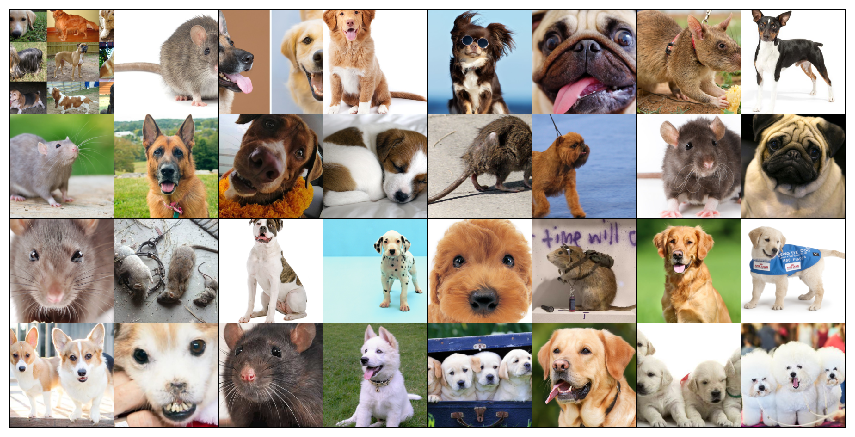

In [137]:
image_grid = utils.make_grid(images)
plot_image(image_grid, figsize=(15,15))

### Prepare training dataset

In [138]:
transformation = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}


In [139]:
dataset = {x: datasets.ImageFolder(os.path.join(root_folder, x), transformation[x]) for x in ['train', 'valid']}
loader = {x: torch.utils.data.DataLoader(dataset[x], batch_size=32, shuffle=True, num_workers=4) for x in ['train', 'valid']}

dataset_size = {x: len(dataset[x]) for x in ['train', 'valid']}
class_names = dataset['train'].classes

In [140]:
dataset_size

{'train': 117, 'valid': 118}

In [141]:
class_names

['dogs', 'rats']

### Classify with original renset

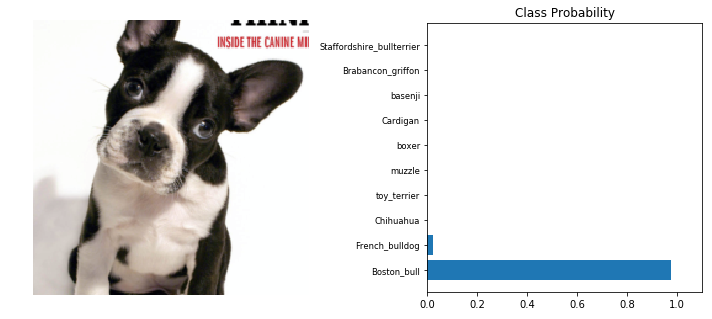

In [142]:
plot_classify(dataset['valid'][41][0], resnet18, topn=10, category_names=get_imagenet_category_names())

## Finetune resnet

In [143]:
from torch import nn, optim

In [36]:
resnet18.fc = nn.Linear(512, 2)
loss_fce = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet18.fc.parameters())

### Basic finetuning of last layers

In [40]:
for param in resnet18.fc.parameters():
    param.requires_grad = True

In [39]:
for param in resnet18.parameters():
    param.requires_grad = False

In [41]:
model = resnet18

In [144]:
def get_valid_acc_and_loss(model, loss_fce, valid_loader):
    accuracy = 0
    loss = 0
    was_training = model.training
    model.eval()
    
    for images, labels in valid_loader:
        predictions = model(images)
        accuracy += (predictions.argmax(dim=1) == labels).type(torch.FloatTensor).mean().item() 
        loss += loss_fce(predictions, labels).item()
    model.train(mode=was_training)
    return accuracy / len(valid_loader) * 100, loss / len(valid_loader)

In [38]:
from collections import deque

# Initial params setup.
epochs = 20
report_period = 3
batch_iteration = 0

# Storing of some data.
train_leak_loss = deque(maxlen=report_period)
train_loss_history = []
valid_loss_history = []
valid_acc_history = []

In [ ]:
for epoch in range(epochs):
    # Setup net to train mode and go through one epoch.
    model.train()
    for images, labels in loader['train']:
        batch_iteration += 1
        
        # Training net on one batch.
        optimizer.zero_grad()
        predictions = model.forward(images)
        loss = loss_fce(predictions, labels)
        loss.backward()
        optimizer.step()
        
        train_leak_loss.append(loss.item())
        # In case we should report, lets make validation on valid set.
        if batch_iteration % report_period == 0:
            model.eval()
            # We don't want to collect info for gradients from here.
            with torch.no_grad():
                valid_accuracy, valid_loss = get_valid_acc_and_loss(model, loss_fce, loader['valid'])
                
            print(f'Epoch: {epoch+1}/{epochs}.. ',
                  f"Train Loss: {round(np.mean(train_leak_loss), 2)}.. ",
                  f"Valid Loss: {round(valid_loss, 2)}.. ",
                  f"Valid Acc: {round(valid_accuracy, 2)}%")
            
            train_loss_history.append(np.mean(train_leak_loss))
            valid_loss_history.append(valid_loss)
            valid_acc_history.append(valid_accuracy)
                        
            model.train()

### Extra finetuning of resnet layer4
Nice reading about advanced strategies for setup of lr ***https://www.jeremyjordan.me/nn-learning-rate/***

 - setup as trainable parameters of last layer of resnet model
 - make learning rate 10 times smaller

In [49]:
optimizer.param_groups[0]['lr']

0.001

In [57]:
optimizer.param_groups[0]['params']

[Parameter containing:
 tensor([[ 0.0007,  0.0338,  0.0195,  ...,  0.0017, -0.0218, -0.0431],
         [ 0.0033, -0.0509, -0.0184,  ..., -0.0118, -0.0391, -0.0218]],
        requires_grad=True), Parameter containing:
 tensor([ 0.0295, -0.0436], requires_grad=True)]

In [58]:
epochs=5

20

In [60]:
for param in model.layer4.parameters():
    param.requires_grad = True

In [62]:
optimizer.param_groups[0]['params'] = optimizer.param_groups[0]['params'] + list(model.layer4.parameters())

In [63]:
optimizer.param_groups[0]['lr'] = 0.0001

### Visualize progress of training

In [66]:
import matplotlib.pylab as plt 

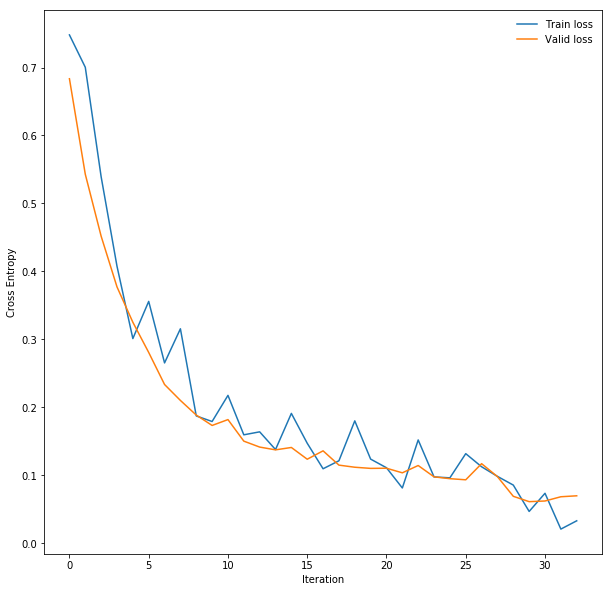

In [67]:
fig = plt.figure(figsize=(10, 10))
ax = plt.gca()
ax.set_xlabel('Iteration')
ax.set_ylabel('Cross Entropy')
plt.plot(train_loss_history, label='Train loss')
plt.plot(valid_loss_history, label='Valid loss')
plt.legend(frameon=False)

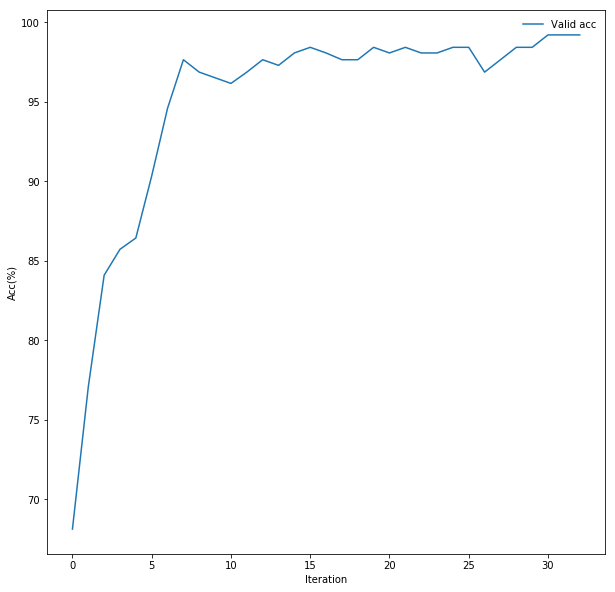

In [68]:
fig = plt.figure(figsize=(10, 10))
plt.plot(valid_acc_history, label='Valid acc')
ax = plt.gca()
ax.set_xlabel('Iteration')
ax.set_ylabel('Acc(%)')
plt.legend(frameon=False)

## Results evaluation

In [69]:
model.fc = torch.nn.Sequential(
    model.fc,
    torch.nn.Softmax(dim=1))

In [73]:
info = model.eval()

### View single images and predictions

In [100]:
from image_processing_workshop.visual import plot_classify, plot_image

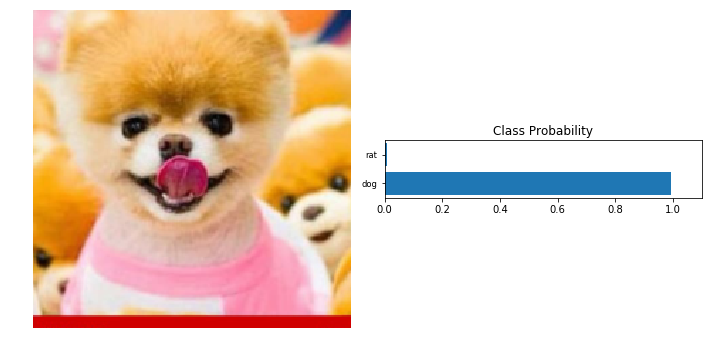

In [101]:
plot_classify(dataset['valid'][1][0], model, category_names=['dog', 'rat'])

### Load reuslts to pandas df

In [78]:
from image_processing_workshop.eval import get_results_df
from image_processing_workshop.visual import plot_df_examples

In [79]:
df = get_results_df(model, loader['valid'])
df.head(10)

label_class_name  label_class_score predicted_class_name_top1  \
0             rats           0.999483                      rats   
1             rats           0.999952                      rats   
2             dogs           0.889069                      dogs   
3             dogs           0.998389                      dogs   
4             dogs           0.983075                      dogs   
5             dogs           0.739834                      dogs   
6             dogs           0.967243                      dogs   
7             dogs           0.993481                      dogs   
8             rats           0.999906                      rats   
9             dogs           0.811203                      dogs   

   predicted_class_score_top1  \
0                    0.999483   
1                    0.999952   
2                    0.889069   
3                    0.998389   
4                    0.983075   
5                    0.739834   
6                    0.967243   
7                    0.993481   
8                    0.999906   
9                    0.811203   

                                               image  
0  [[[1.033050775527954, 0.9303022623062134, 0.89...  
1  [[[2.0605359077453613, 2.0434112548828125, 2.0...  
2  [[[-1.1417930126190186, -1.1417930126190186, -...  
3  [[[-0.4396780729293823, -0.4568028450012207, -...  
4  [[[-0.5766761302947998, -0.6451750993728638, -...  
5  [[[1.63241708278656, 1.63241708278656, 1.59816...  
6  [[[2.0605359077453613, 2.0605359077453613, 2.0...  
7  [[[-0.7821731567382812, -1.2445416450500488, -...  
8  [[[1.2042982578277588, 1.2214230298995972, 1.2...  
9  [[[0.022690238431096077, 0.022690238431096077,...

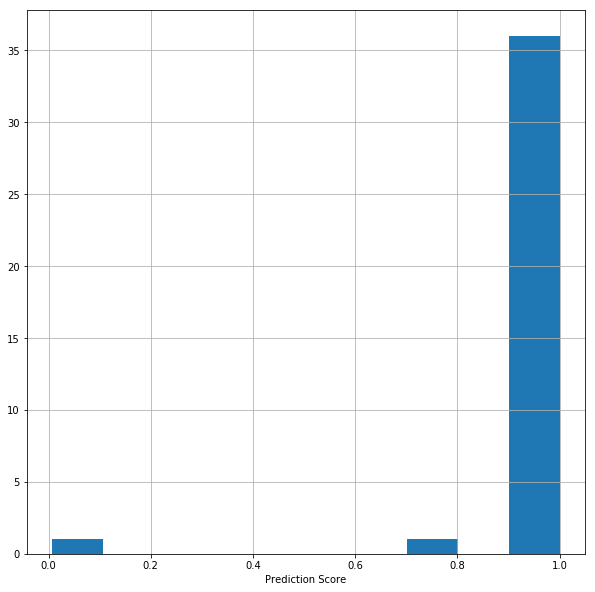

In [80]:
fig = plt.figure(figsize=(10, 10))
ax = plt.gca()
ax.set_xlabel('Prediction Score')
df[df.label_class_name=='rats'].label_class_score.hist(ax=ax)

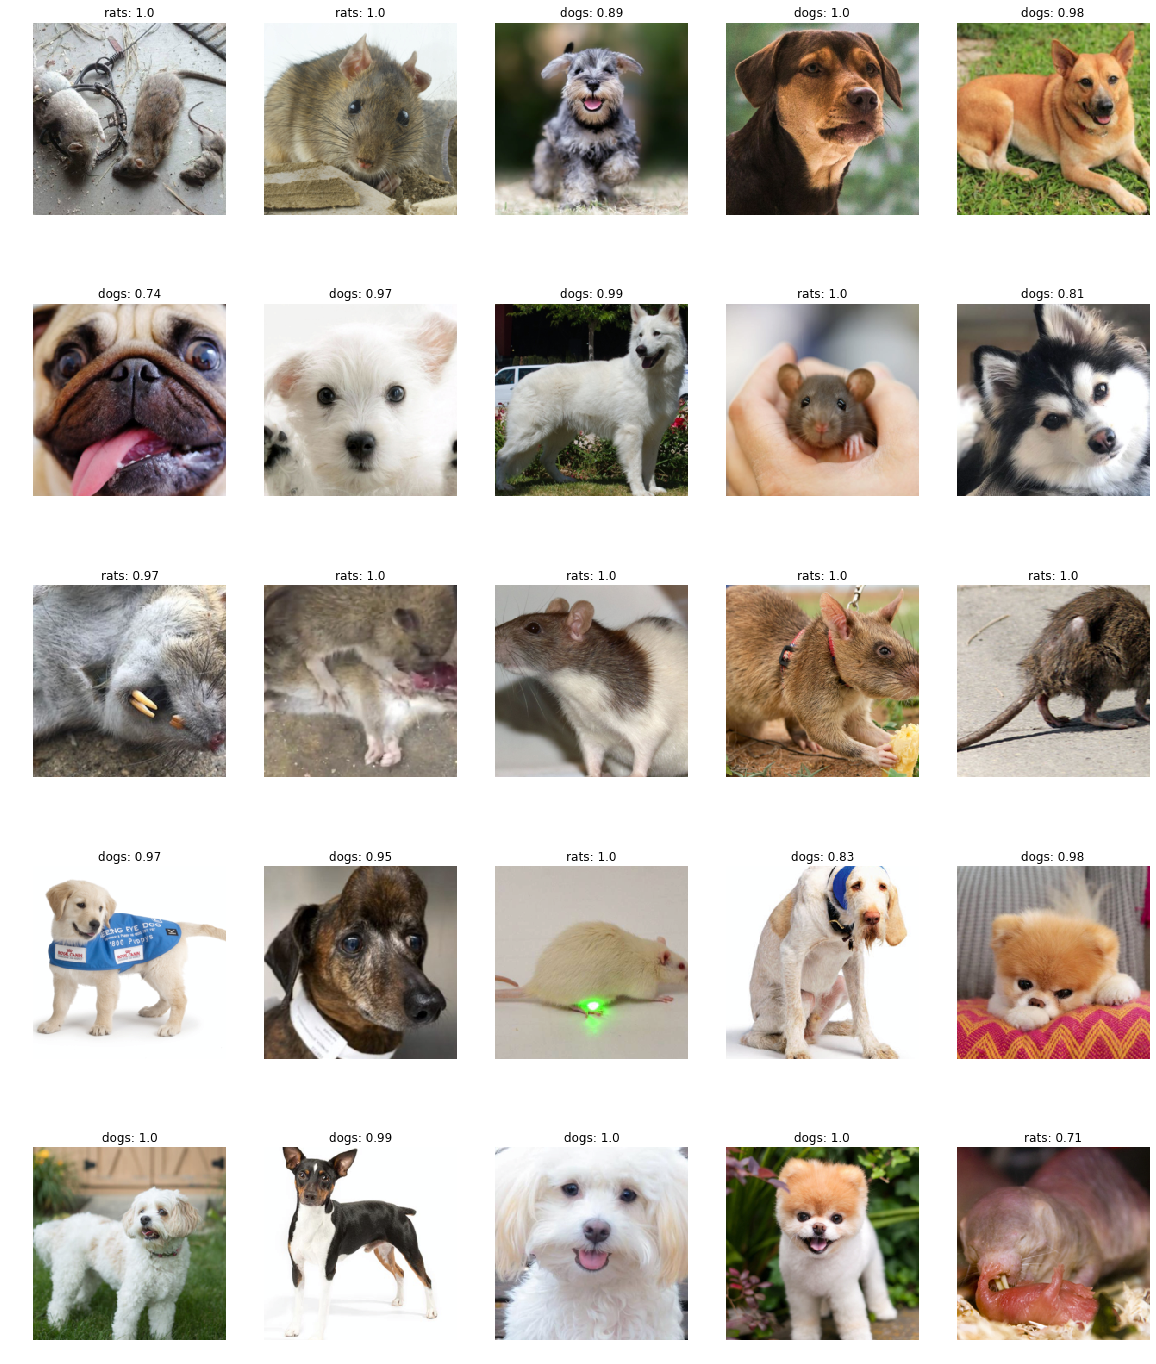

In [102]:
plot_df_examples(df.iloc[:25])

### Overall Recall and Precision


In [86]:
from image_processing_workshop.eval import get_rec_prec

In [88]:
get_rec_prec(df, ['rats', 'dogs'])

class_name  recall  precision
0       rats   97.37      97.37
1       dogs   98.75      98.75

### Accuracy

In [89]:
from image_processing_workshop.eval import get_accuracy

In [90]:
get_accuracy(df)

98.31

### False Positives

In [103]:
from image_processing_workshop.eval import get_false_positives

In [104]:
fp = get_false_positives(df, label_class_name='dogs')

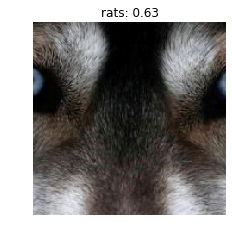

In [105]:
plot_df_examples(fp)

### Confusion Matrix

In [96]:
from image_processing_workshop.visual import plot_coocurance_matrix

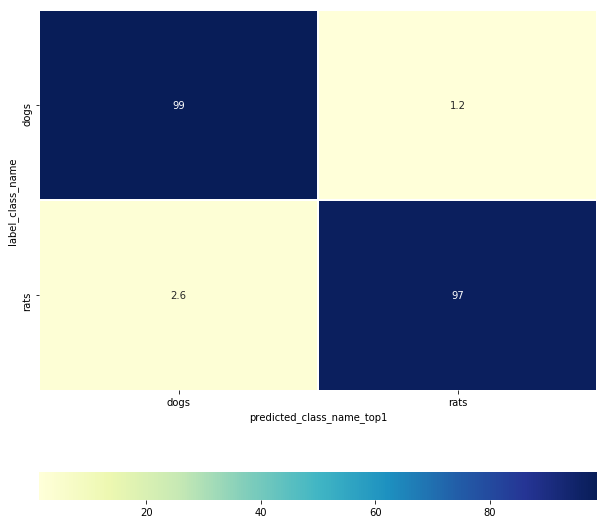

In [97]:
plot_coocurance_matrix(df, use_log=False)